In [2]:
!nvidia-smi

Wed Jan 10 06:14:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   28C    P8              19W / 450W |  19420MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import necessary package

In [3]:
from sklearn.metrics import roc_auc_score
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import random


# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def resize_it(x):
    if x.shape != (512, 512):
        x = cv2.resize(x, dsize=(512, 512), interpolation=cv2.INTER_LINEAR)
    return x


[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


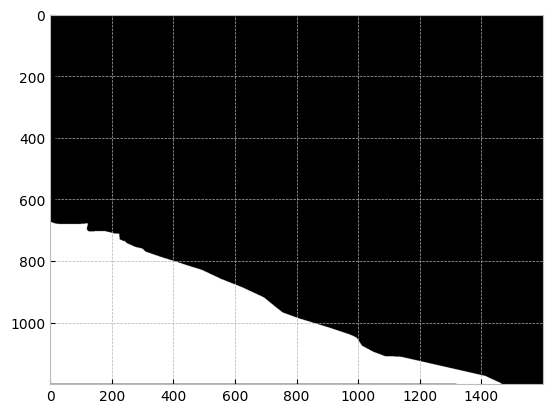

In [5]:
# simple testing
img_path = './dataset/train/image/1.jpg'
mask_path = './dataset/train/mask/1.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_it(img)
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#mask = resize_it(mask)

#tmp_img = image.swapaxes(0, 1)
#tmp_img = tmp_img.swapaxes(1, 2)
plt.imshow(mask)
print(mask)


In [6]:
#customized dataset
class WaterDataset(Dataset):
    """
        Args:
            images_dir (str): image file directory
            masks_dir (str): ground truth directory
            class_values (list): segmentation class num
            augmentation (albumentations.Compose): for data augmentation
            preprocessing (albumentations.Compose): for data preprocrssing
    """

    def __init__(
            self,
            images_dir,
            masks_dir = None,
            augmentation=None,
            preprocessing=None,
            classes=None,
            transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        
        self.ids = os.listdir(images_dir)
        if '.ipynb_checkpoints' in self.ids:
            self.ids.remove('.ipynb_checkpoints')
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

        if masks_dir != None:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transforms = transforms

    def __getitem__(self, idx):


        #if idx == 34:
        #    idx = 33

        # read data
        img = cv2.imread(self.images_fps[idx])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # resize image
        img = resize_it(img)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = None

        if self.masks_fps != None:
            mask = cv2.imread(self.masks_fps[idx], cv2.IMREAD_GRAYSCALE)

            # resize mask
            mask = resize_it(mask)
            new_mask = mask
    
            for i in range(512):
                for j in range(512):
                    if mask[i][j] > 200:
                        mask[i][j] = 1
                    else:
                        mask[i][j] = 0
    
            mask = np.expand_dims(mask, axis = 2)
                     

        # for data augmentation
        if self.augmentation:
            if self.masks_fps != None:
                sample = self.augmentation(image=img, mask=mask)
                img, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=img)
                img = sample['image']
                mask = None
            
 
        # for data preprocessing
        if self.preprocessing:
            if self.masks_fps != None:
                sample = self.preprocessing(image=img, mask=mask)
                img, mask = sample['image'], sample['mask']
            else:
                sample = self.preprocessing(image=img)
                img = sample['image']
                mask = None

        return img, mask

    def __len__(self):
        return len(self.ids)


In [7]:
# data augmentation
def get_training_augmentation():
    train_transform = [
 
        albu.HorizontalFlip(p=0.5),
 
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
 
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
 
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
 
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
           ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)
 
 
def get_validation_augmentation():

    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)
 
 
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
 
# data preprocessing
def get_preprocessing(preprocessing_fn):
    """ image preprocessing
    Args:
        preprocessing_fn (callbale): 
    Return:
        transform: albumentations.Compose
    """
 
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)



In [8]:
# set training config
training_config = {
    'n_epochs': 50,
    'batch_size': 5,
    'lr': 1e-4,
    'seed': 8787,
    'N_FOLDS': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'

}


In [9]:
#ENCODER = 'se_resnext50_32x4d'
ENCODER = 'dpn68b'              # resnet101
ENCODER_WEIGHTS = 'imagenet+5k'    # imagenet
CLASSES = ['water']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
 
# create segmentation model with pretrained FPN model
# model = smp.FPN(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES),
#     activation=ACTIVATION,
# )

# create segmentation model with pretrained unet++ model
model = smp.UnetPlusPlus(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION,
)

# create segmentation model with pretrained DeepLabV3Plus model
#model = smp.DeepLabV3Plus(
#    encoder_name=ENCODER, 
#    encoder_weights=ENCODER_WEIGHTS, 
#    classes=len(CLASSES), 
#    activation=ACTIVATION,
#)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# data directory
DATA_DIR = './dataset'
#DATA_DIR = './dataset/after_preprocessing'

# training set
x_train_dir = os.path.join(DATA_DIR, 'train', 'image')
y_train_dir = os.path.join(DATA_DIR, 'train', 'mask')

# validation set
x_valid_dir = os.path.join(DATA_DIR, 'validation', 'image')
y_valid_dir = os.path.join(DATA_DIR, 'validation', 'mask')


# load training data
train_dataset = WaterDataset(
    x_train_dir,
    y_train_dir,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# load validation data
valid_dataset = WaterDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# set data loader
train_loader = DataLoader(train_dataset, batch_size = training_config['batch_size'], shuffle = True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle = False, num_workers = 0)

loss = smp.utils.losses.DiceLoss()


# set IOU threshold
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=training_config['lr']),
])
 
# iterate samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = training_config['device'],
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = training_config['device'],
    verbose = True,
)

seed_everything(training_config['seed'])


/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/alb

In [51]:
print(f"device: {training_config['device']}")


device: cuda


## Start training

In [16]:

max_score = 0

# start training
for i in range(0, training_config['n_epochs']):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
		
    # save the best model
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './save_check_point/after_preprocessing_dpn68b_best_model.pth')
        print('Model saved!')
        
    #if i == 25:
        #optimizer.param_groups[0]['lr'] = 1e-5


Epoch: 0
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s, dice_loss - 0.5094, iou_score - 0.4357]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s, dice_loss - 0.4123, iou_score - 0.6382]
Model saved!

Epoch: 2
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s, dice_loss - 0.3598, iou_score - 0.5719]

Epoch: 3
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s, dice_loss - 0.3269, iou_score - 0.6087]

Epoch: 4
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s, dice_loss - 0.2701, iou_score - 0.6971]
Model saved!

Epoch: 5
valid: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s, dice_loss - 0.2746, iou_score - 0.6965]

Epoch: 6
valid: 100%|███

## Testing

image shape: (3, 512, 512)


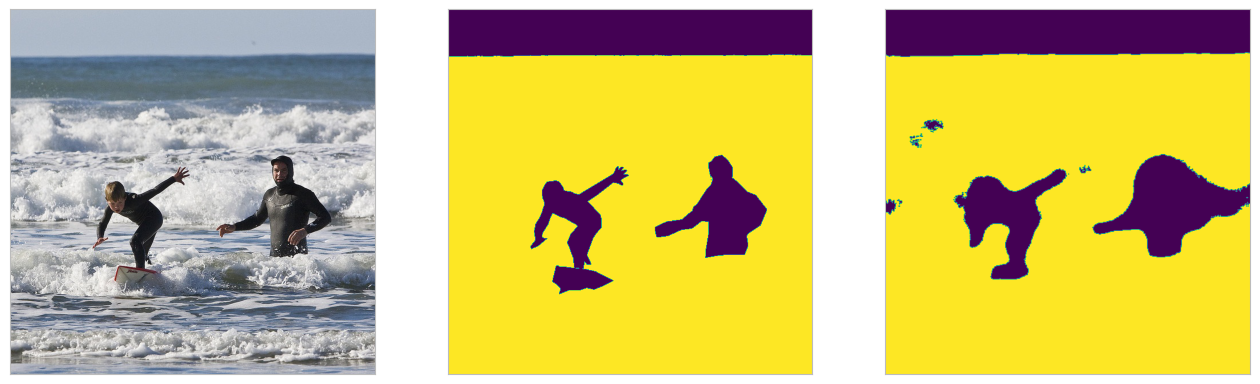

test iou score 0: 0.9433802962303162
image shape: (3, 512, 512)


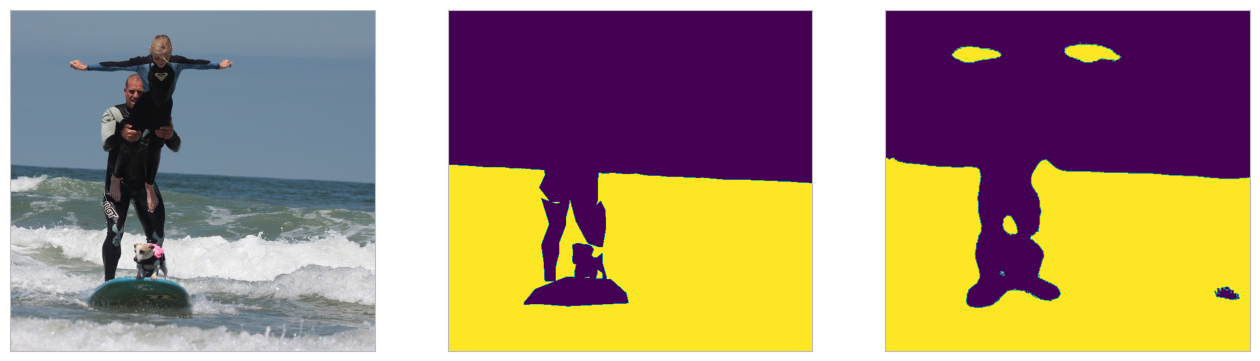

test iou score 1: 0.9130973219871521
image shape: (3, 512, 512)


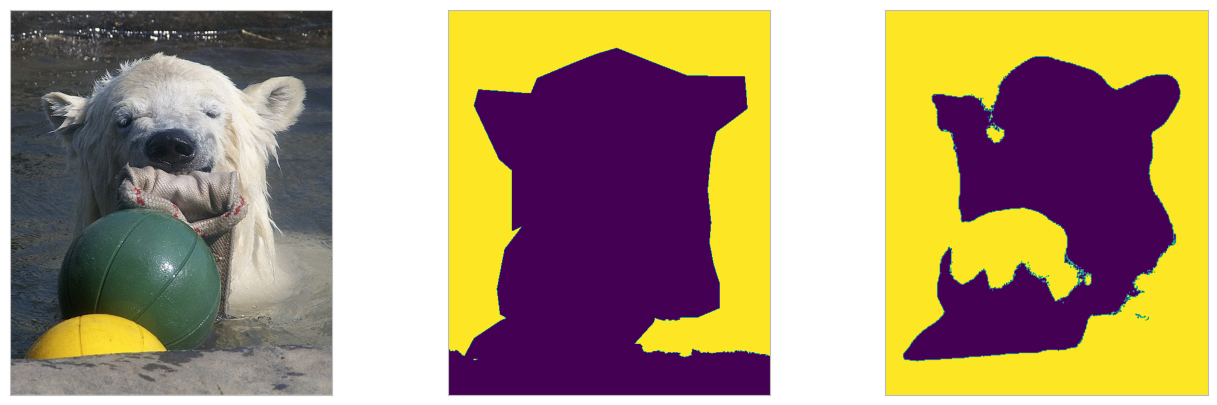

test iou score 2: 0.6231775879859924
image shape: (3, 512, 512)


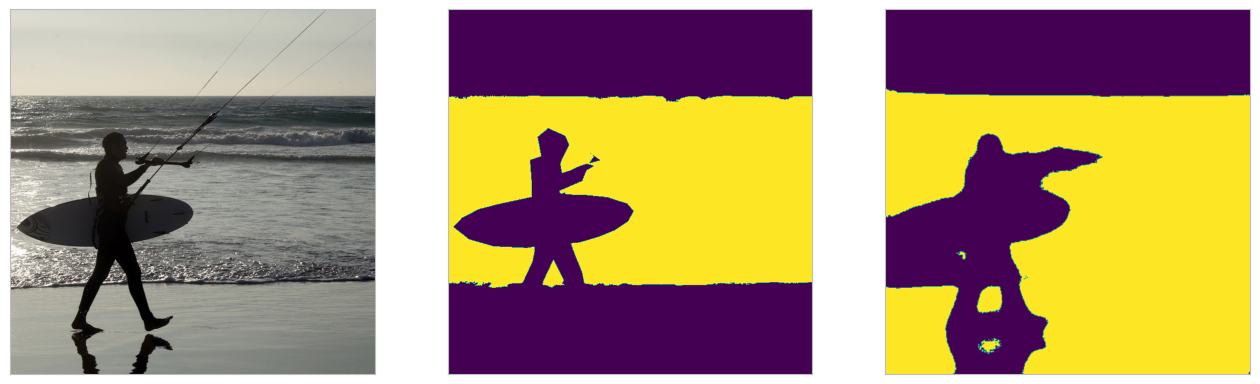

test iou score 3: 0.5989786982536316
image shape: (3, 512, 512)


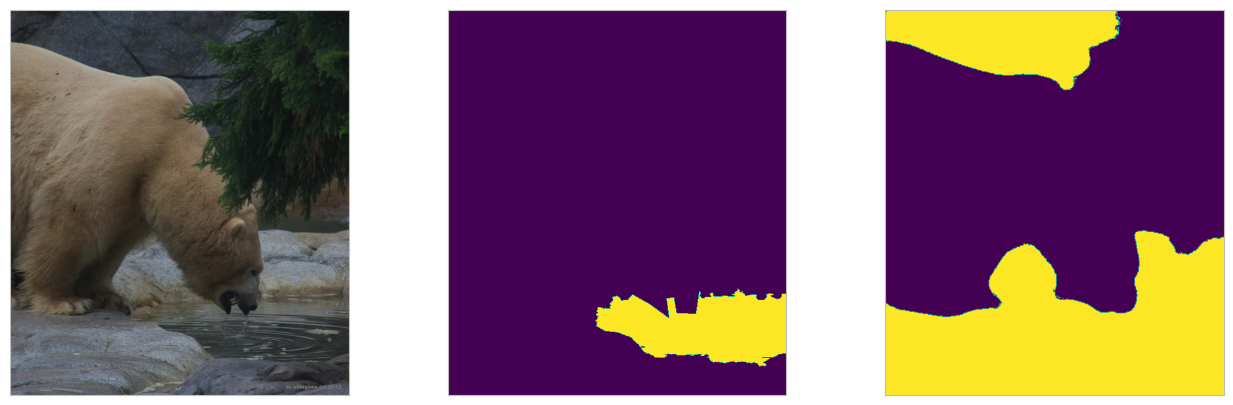

test iou score 4: 0.19017697870731354
avg test iou score: 0.6537622213363647


In [17]:
#test.py
def get_test_augmentation():
    # reshape the image
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)
 
 
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
 
 
def get_preprocessing(preprocessing_fn):
    """test data preprocessing
    Args:
        preprocessing_fn (callbale): 
    Return:
        transform: albumentations.Compose
    """
 
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
 
 
# visualize image segmentation result
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        #print(f'name: {name}, image: {image}')

        #if name == 'ground_truth_mask':
        #    image = image.swapaxes(0, 1)
        #    image = image.swapaxes(1, 2)
        #tmp_img = image.swapaxes(0, 1)
        #tmp_img = tmp_img.swapaxes(1, 2)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        #print(image.shape)
        plt.imshow(image)
    plt.show()
 
 
# ------------------------------------------------------------testing ---------------------------------------------------------------

# testing set
x_test_dir = os.path.join(DATA_DIR, 'test', 'image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'mask')

# 要改！！！
ENCODER = 'dpn68b'              # resnet101
ENCODER_WEIGHTS = 'imagenet+5k'    # imagenet
CLASSES = ['water']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# ---------------------------------------------------------------
# load best model
best_model = torch.load('./save_check_point/dpn68b_best_model.pth')

# load testing dataset
#DATA_DIR = './dataset'
x_test_dir = os.path.join(DATA_DIR, 'test', 'image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'mask')

# testing dataset
test_dataset = WaterDataset(
    x_test_dir,
    y_test_dir,
    augmentation = get_test_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)
 
# ---------------------------------------------------------------

test_dataset_vis = WaterDataset(
    x_test_dir, y_test_dir,
    classes = CLASSES,
)

criterion = smp.utils.metrics.IoU(threshold=0.5)
iou_scores = 0

# image 和 mask 檔名要一樣
ids = os.listdir(x_test_dir)
images_fps = [os.path.join(x_test_dir, image_id) for image_id in ids]
gts_fps = [os.path.join(y_test_dir, image_id) for image_id in ids]
skip = 0
predict_path = './dataset/predict'

# testing when you have ground truth and calculate IOU score
for idx in range(len(test_dataset.ids)): #5
    
    n = idx 
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset.__getitem__(n)
    # image, gt_mask = test_dataset[n]
    #tmp_img = image.swapaxes(0, 1)
    #tmp_img = tmp_img.swapaxes(1, 2)
    #tmp_gt_mask = gt_mask.swapaxes(0, 1)
    #tmp_gt_mask = tmp_gt_mask.swapaxes(1, 2)
    #plt.imshow(tmp_gt_mask)
    #raise
    gt_mask = gt_mask.squeeze()
    print(f'image shape: {image.shape}')
    
    if images_fps[n] == './only_test/.ipynb_checkpoints':
        skip = 1

    ori_img = plt.imread(images_fps[n+skip])
    ori_gt = plt.imread(gts_fps[n])
    ori_gt = ori_gt.squeeze()

    x_tensor = torch.from_numpy(image).to(training_config['device']).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    
    filename = predict_path + '/one_model_predict_withIOU_' + str(idx + 1) + '.jpg'
            
    pr_mask = cv2.resize(pr_mask, (ori_img.shape[1], ori_img.shape[0]))
    pr_mask_uint8 = (pr_mask * 255).astype('uint8')
    cv2.imwrite(filename, pr_mask_uint8) 
        
    
    #tmp_pr_mask = pr_mask.swapaxes(0, 1)
    #tmp_pr_mask = tmp_pr_mask.swapaxes(1, 2)
    #plt.imshow(tmp_pr_mask)

    visualize(
        image = ori_img,
        ground_truth_mask = ori_gt,
        predicted_mask = pr_mask
    )

    iou_score = criterion.forward(torch.from_numpy(pr_mask), torch.from_numpy(ori_gt))
    iou_scores += iou_score

    # (predict, ground_truth)
    print(f'test iou score {idx}: {iou_score}')


            
            

print(f'avg test iou score: {iou_scores / len(test_dataset.ids)}')
#print(f'gt_mask: {gt_mask[0][0]}')
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


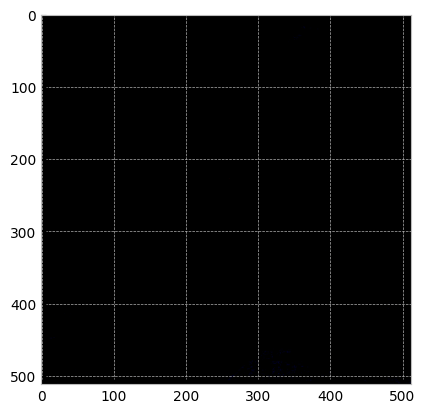

In [39]:
tmp_img = image.swapaxes(0, 1)
tmp_img = tmp_img.swapaxes(1, 2)
    
plt.imshow(tmp_img)

images_fps: ['./only_test/.ipynb_checkpoints', './only_test/input7.jpg', './only_test/input11.jpg', './only_test/input9.jpg', './only_test/input8.jpg', './only_test/input1.jpg', './only_test/input6.jpg', './only_test/input10.jpg', './only_test/input5.jpg', './only_test/input2.jpg', './only_test/input3.jpg', './only_test/input4.jpg', './only_test/input12.jpg']
pr_mask.shape: (1068, 736)


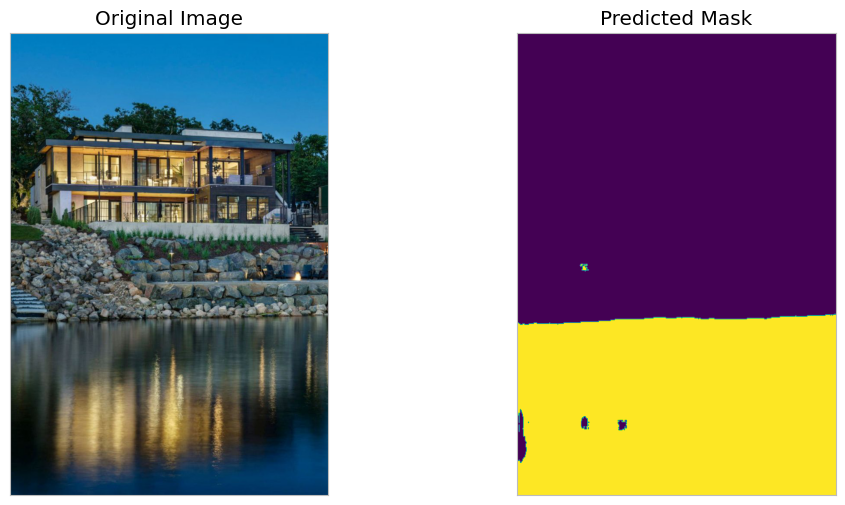

pr_mask.shape: (318, 450)


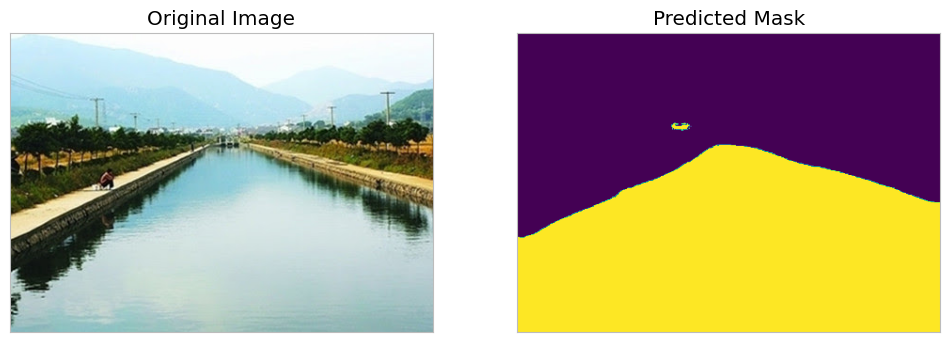

pr_mask.shape: (397, 600)


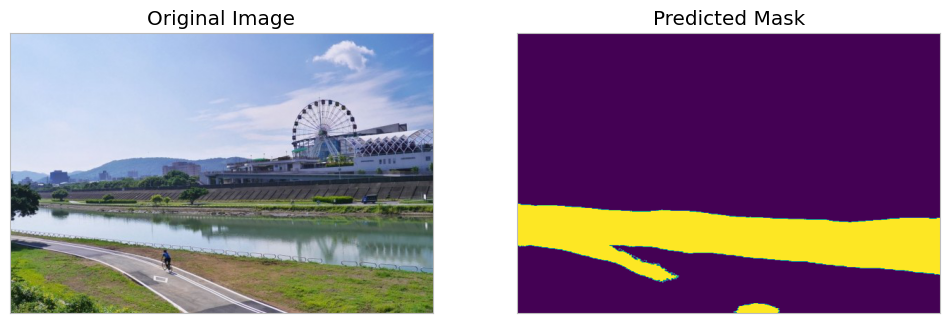

pr_mask.shape: (1128, 536)


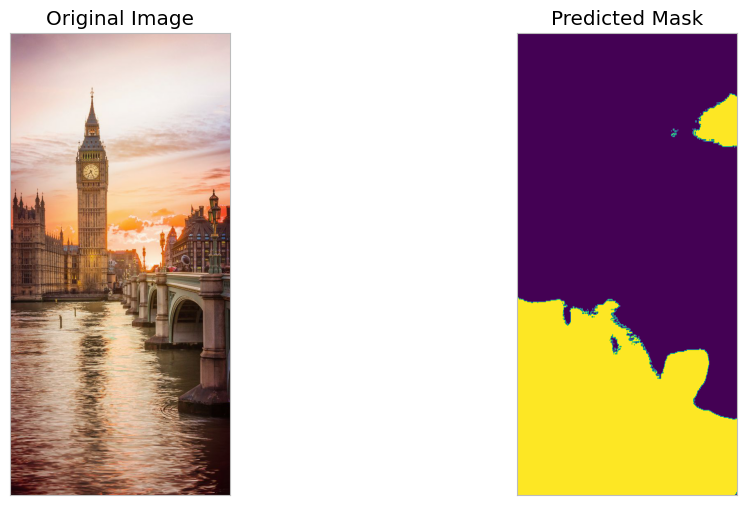

pr_mask.shape: (881, 736)


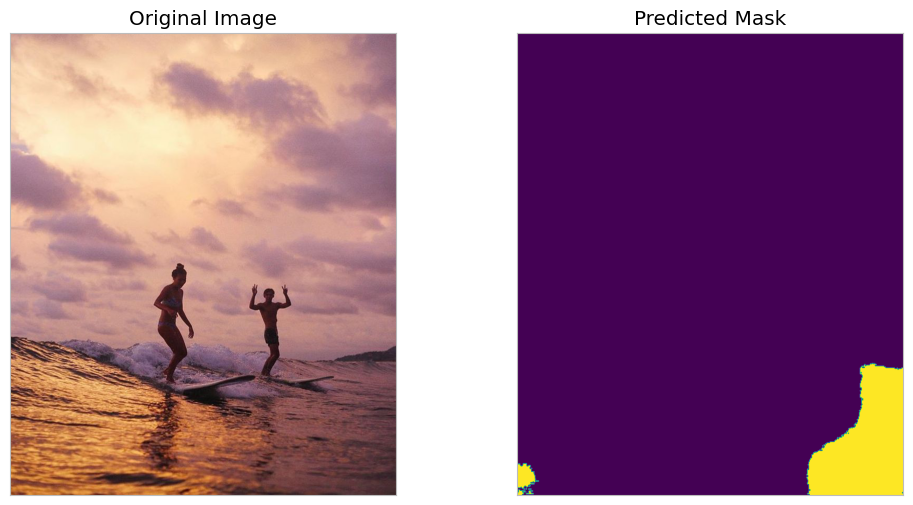

pr_mask.shape: (552, 736)


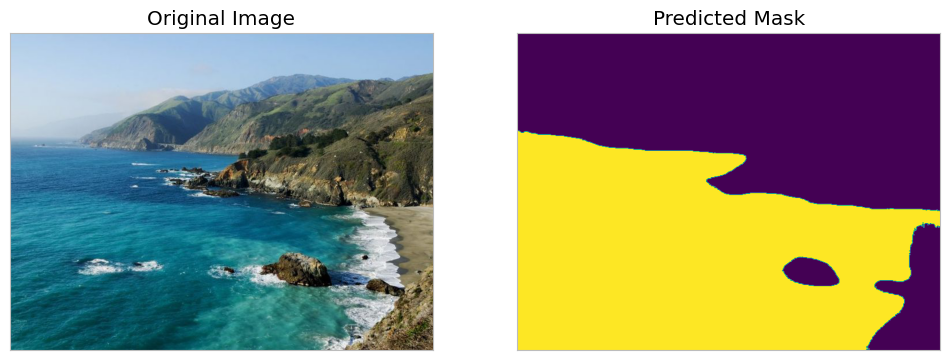

pr_mask.shape: (450, 800)


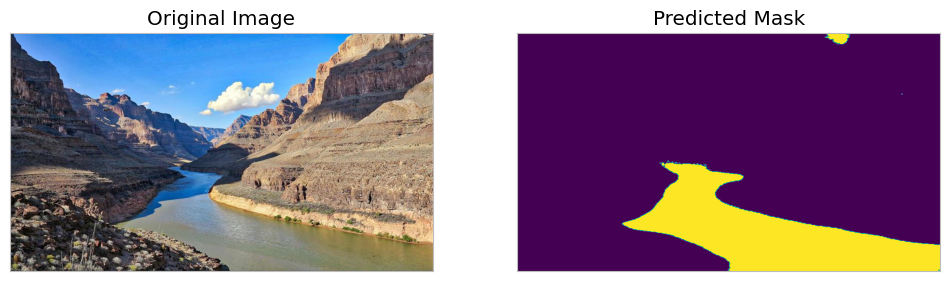

pr_mask.shape: (1308, 736)


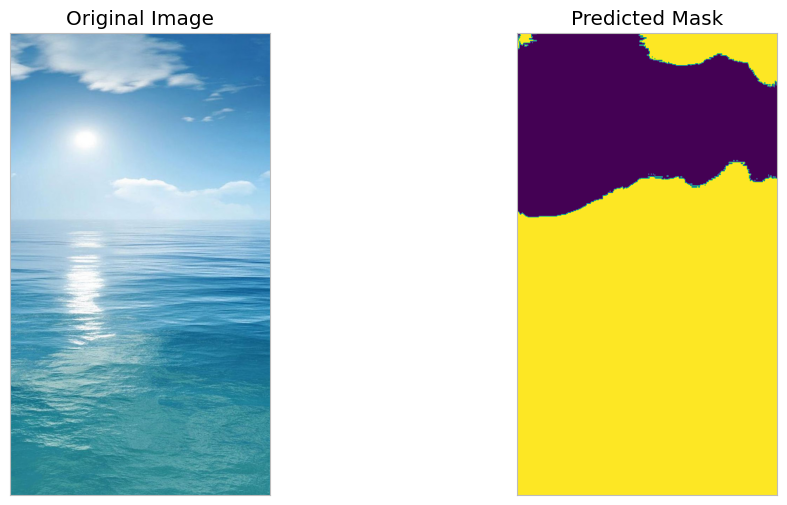

pr_mask.shape: (1080, 720)


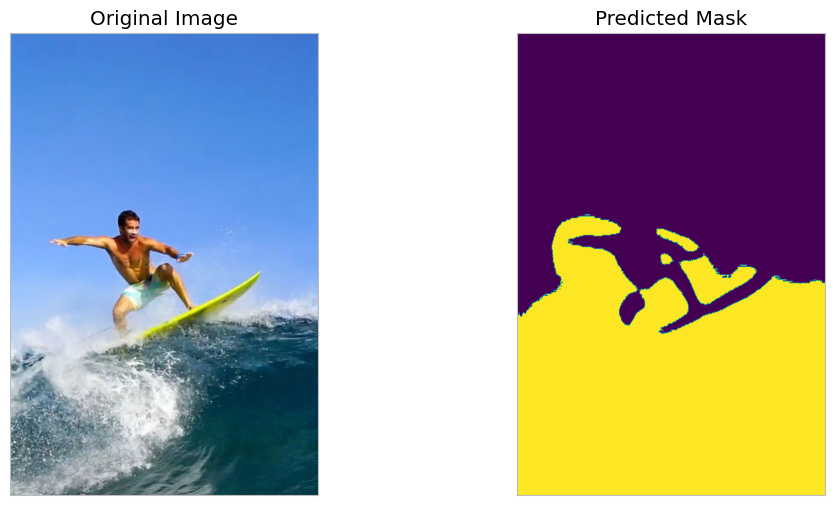

pr_mask.shape: (1280, 720)


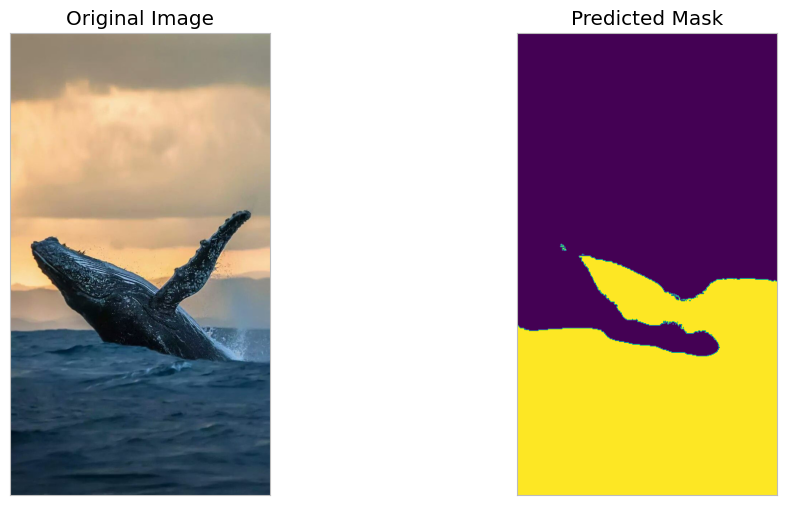

pr_mask.shape: (750, 500)


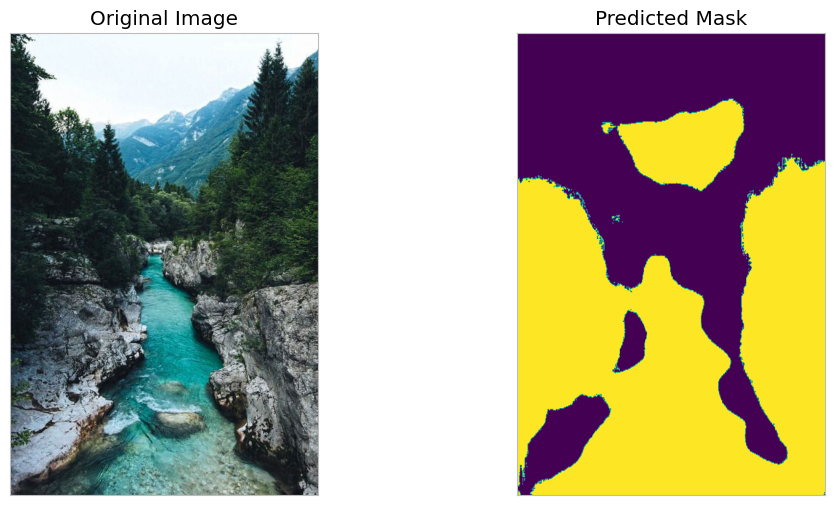

pr_mask.shape: (1096, 577)


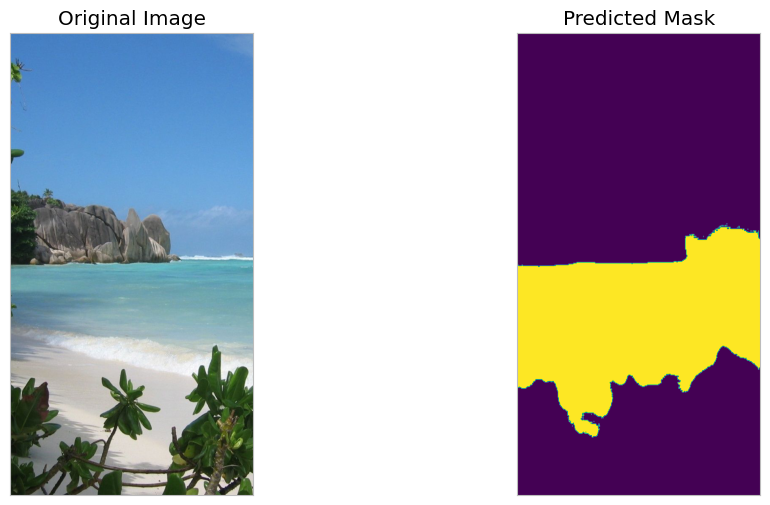

In [50]:
# testing when you don't have ground truth
def test_no_iou():

    #tmp_DIP_final_project/only_test/56.jpg
    test_data_dir = './only_test'
    ids = os.listdir(test_data_dir)
    images_fps = [os.path.join(test_data_dir, image_id) for image_id in ids]
    print(f'images_fps: {images_fps}')
    predict_path = './dataset/predict'


    ENCODER = 'dpn68b'              # resnet101
    ENCODER_WEIGHTS = 'imagenet+5k'    # imagenet
    CLASSES = ['water']
    ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    # testing dataset
    test_dataset = WaterDataset(
        images_dir = test_data_dir,
        augmentation = get_test_augmentation(),
        preprocessing = get_preprocessing(preprocessing_fn),
        classes = CLASSES,
    )
     
    # ---------------------------------------------------------------
    
    test_dataset_vis = WaterDataset(
        images_dir = test_data_dir,
        classes = CLASSES,
    )

    # load best model
    best_model = torch.load('./save_check_point/dpn68b_best_model.pth').to(training_config['device'])
    skip = 0
    
    with torch.no_grad():
        best_model.eval()
        # calculate average predict mask

        for idx in range(len(test_dataset.ids)): # 3

            n = idx 
            image_vis = test_dataset_vis[n][0].astype('uint8')
            #image, gt_mask = test_dataset[n]
            image, gt_mask = test_dataset.__getitem__(n)

            if images_fps[n] == './only_test/.ipynb_checkpoints':
                skip = 1

            ori_img = plt.imread(images_fps[n + skip])
            index = images_fps[n + skip].split('./only_test/input')
            index = index[1].split('.jpg')[0]
        
            x_tensor = torch.from_numpy(image).to(training_config['device']).unsqueeze(0)
            pr_mask = best_model.predict(x_tensor)
            pr_mask = (pr_mask.squeeze().cpu().numpy().round())

            #filename = predict_path + '/one_model_predict_' + str(idx + 1) + '.jpg'
            filename = predict_path + '/output' + index + '.jpg'
            #print(f'image.shape: {image.shape}')
            #print(f'pr_mask.shape: {pr_mask.shape}')
   
            # Saving the image 
            pr_mask = cv2.resize(pr_mask, (ori_img.shape[1], ori_img.shape[0]))
            pr_mask_uint8 = (pr_mask * 255).astype('uint8')
            cv2.imwrite(filename, pr_mask_uint8) 

            print(f'pr_mask.shape: {pr_mask.shape}')
            

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(ori_img)
            plt.title("Original Image")
            plt.xticks([])
            plt.yticks([])
        
            plt.subplot(1, 2, 2)
            plt.imshow(pr_mask)
            plt.title("Predicted Mask")
            plt.xticks([])
            plt.yticks([])
        
            plt.show()
             


test_no_iou()

In [45]:
# 助教的 IOU 算法

import cv2
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# 假設你有10對mask的檔案名稱，這裡只是一個例子，請替換成你的實際檔案名稱
gt_test_dir = './dataset/test/mask/'
pred_test_dir = './dataset/predict/'

mask_filenames_1 = ["output1.jpg", "output2.jpg", "output3.jpg", "output4.jpg", "output5.jpg"]
mask_filenames_2 = ["56.jpg",  "57.jpg", "58.jpg", "59.jpg", "60.jpg"]

total_iou = 0

for i in range(5):  # 修改為實際的mask數量
    # 讀取兩個mask
    mask1 = cv2.imread(pred_test_dir + mask_filenames_1[i], cv2.IMREAD_GRAYSCALE) 
    mask2 = cv2.imread(gt_test_dir + mask_filenames_2[i], cv2.IMREAD_GRAYSCALE)

    # 將mask二值化 (假設是二值化的黑白圖片)
    _, mask1 = cv2.threshold(mask1, 128, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(mask2, 128, 255, cv2.THRESH_BINARY)

    # 計算IOU並加總
    iou = calculate_iou(mask1, mask2)
    total_iou += iou
    print(f"IoU for pair {i + 1}: {iou}")

# 計算平均IoU
average_iou = total_iou / len(mask_filenames_1)
print(f"Average IoU: {average_iou}")



IoU for pair 1: 0.9434072047915973
IoU for pair 2: 0.5989680201775159
IoU for pair 3: 0.9131567101794097
IoU for pair 4: 0.6230901801931537
IoU for pair 5: 0.19014589981025207
Average IoU: 0.6537536030303858
